In [1]:
import tensorflow as tf
import numpy as np
import os, time
import scipy.misc as misc
import matplotlib.pyplot as plt

In [2]:
# CONSTANT
TRAIN_DATA_PATH = '/home/minsisi/FACADES_TRAIN_DATASET/'
TEST_DATA_PATH = '/home/minsisi/FACADES_TEST_DATASET/'

EPS = 1e-12
IMAGE_SIZE = 256

EPOCH = 50
LEARNING_RATE = 0.0002
BETA1 = 0.5
L1_WEIGHT = 100.0
GAN_WEIGHT = 1.0

In [3]:
# get training label, target image names
label_image_names = list()
target_image_names = list()

for (path, dir, files) in os.walk(TRAIN_DATA_PATH):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.png':
            label_image_names.append(filename)
        elif ext == '.jpg':
            target_image_names.append(filename)            

label_image_names.sort()
target_image_names.sort()
train_image_numbers = len(label_image_names)

In [4]:
# # for image process
def visualize_img(x):
    return np.clip(x, 0, 255).astype('uint8')

def read_img(img_path):
    img = misc.imread(img_path)
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        img = np.dstack((img,img,img))
    
    return misc.imresize(img, (IMAGE_SIZE,IMAGE_SIZE,3))

# 0~255 --> -1 ~ 1
def preprocess_img(img):
    return (img-255/2)/(255/2)

#  -1 ~ 1 --> 0 ~ 255
def deprocess_img(img):
    return (img*255/2) + 255/2

# generator

In [5]:
def lrelu(x, leak=0.2):
    return tf.maximum(x, leak*x)      

def conv2(h, k, s):
    with tf.variable_scope('conv'):
        in_ch = h.get_shape().as_list()[-1]
        w = tf.get_variable('w', [4,4, in_ch, k],dtype=tf.float32, initializer=tf.random_normal_initializer(0, 0.02))
        h = tf.pad(h, [ [0,0], [1,1], [1,1], [0,0]], mode="REFLECT")
        h = tf.nn.conv2d(h, w, [1, s, s, 1], padding="VALID")
        return h

def batch_norm(h):

    in_ch = h.get_shape().as_list()[-1]       
    offset = tf.get_variable("offset", [in_ch], dtype=tf.float32, initializer=tf.zeros_initializer())
    scale = tf.get_variable("scale", [in_ch], dtype=tf.float32, initializer=tf.random_normal_initializer(1.0, 0.02))
    mean, sig_sq = tf.nn.moments(h, axes=[0, 1, 2], keep_dims=False)
    h = tf.nn.batch_normalization(h, mean, sig_sq, offset, scale, variance_epsilon=1e-3)

    return h


def conv_block(h, k, s=2, bn=True, relu = True):
    if relu : h = lrelu(h)
    h = conv2(h,k,s)
    if bn : h = batch_norm(h)
    return h

def deconv_block(h, k,s=2, drop=False, relu=True,bn =True):
    if relu : h = tf.nn.relu(h)
    h = tf.contrib.layers.conv2d_transpose(h, k, [4,4],s, activation_fn=None)
    if bn : h = batch_norm(h)
    if drop : h = tf.nn.dropout(h, keep_prob=0.5)
        
    return h
        

In [6]:
def generator(h):
    with tf.variable_scope('e1'):
        e1 = conv_block(h, 64, bn=False, relu=False) # size, ch : 128, 64
    with tf.variable_scope('e2'):
        e2 = conv_block(e1 , 128) # size, ch : 64, 128
    with tf.variable_scope('e3'):
        e3 = conv_block(e2 , 256) # size, ch : 32, 256
    with tf.variable_scope('e4'):
        e4 = conv_block(e3 , 512) # size, ch : 16, 512
    with tf.variable_scope('e5'):
        e5 = conv_block(e4 , 512) # size, ch : 8, 512
    with tf.variable_scope('e6'):
        e6 = conv_block(e5 , 512) # size, ch : 4, 512
    with tf.variable_scope('e7'):
        e7 = conv_block(e6 , 512) # size, ch : 2, 512
    with tf.variable_scope('e8'):
        e8 = conv_block(e7 , 512) # size, ch : 1, 512
    
    with tf.variable_scope('d1'):
        d1 = deconv_block(e8, 512, drop=True) # size, ch : 2, 512
    with tf.variable_scope('d2'):
        d2 = tf.concat([d1, e7], axis=3) # size, ch : 2, 1024
        d2 = deconv_block(d2, 512, drop=True) # size, ch : 4, 512
    with tf.variable_scope('d3'):
        d3 = tf.concat([d2, e6], axis=3) # size, ch : 4, 1024
        d3 = deconv_block(d3, 512, drop=True) # size, ch : 8, 512
    with tf.variable_scope('d4'):
        d4 = tf.concat([d3, e5], axis=3) # size, ch : 8, 1024
        d4 = deconv_block(d4, 512) # size, ch : 16, 512
    with tf.variable_scope('d5'):
        d5 = tf.concat([d4, e4], axis=3) # size, ch : 16, 1024
        d5 = deconv_block(d5, 256) # size, ch : 32, 256
    with tf.variable_scope('d6'):
        d6 = tf.concat([d5, e3], axis=3) # size, ch : 32, 512
        d6 = deconv_block(d6, 128) # size, ch : 64, 128
    with tf.variable_scope('d7'):
        d7 = tf.concat([d6, e2], axis=3) # size, ch : 64, 256
        d7 = deconv_block(d7, 64) # size, ch : 128, 64
    with tf.variable_scope('d8'):
        d8 = tf.concat([d7, e1], axis=3) # size, ch : 128, 64
        d8 = tf.nn.relu(d8) # size, ch : 128, 64
    with tf.variable_scope('d_out'):
        output = deconv_block(d8, 3) # size, ch : 256, 3
    return tf.nn.tanh(output) # size, ch : 256, 3

In [7]:
def discriminator(inp, tar):
    with tf.variable_scope('discrminator1'):
        h = tf.concat([inp, tar], axis=3)
        h = tf.contrib.layers.conv2d(h, 64, [4,4], 2, activation_fn=None) # 128, 64

    with tf.variable_scope('discrminator2'):
        h = conv_block(h, 128) # 64, 128
    with tf.variable_scope('discrminator3'):
        h = conv_block(h, 256) # 32, 256
    with tf.variable_scope('discrminator4'):
        h = conv_block(h, 512,1) # 31, 512
    with tf.variable_scope('discrminator5'):
        h = conv_block(h, 1,1, bn=False, relu=False)
        h = tf.sigmoid(h)
    return h
    
    

## how to learning?
### 1) 랜덤하게 label image에서 generate하던가 ground truth를 비교하던가
### 2) 한번에 두개다(how?) --> https://affinelayer.com/pix2pix/index.html 참고
## 2번 방법으로 학습

In [8]:
# image placeholders

# label images
inputs = tf.placeholder(shape=[1, IMAGE_SIZE, IMAGE_SIZE, 3], dtype=tf.float32)

# facades images
targets = tf.placeholder(shape=[1, IMAGE_SIZE,IMAGE_SIZE,3], dtype =tf.float32)


In [9]:
#
with tf.variable_scope("generator") as scope:
    outputs = generator(inputs)

with tf.name_scope('real_discriminator'):
    with tf.variable_scope('discriminator'):
        real_d = discriminator(inputs, targets)

# reuse same variabels
with tf.name_scope('fake_discriminator'):
    with tf.variable_scope('discriminator', reuse=True):
        fake_d = discriminator(inputs, outputs)

# calc losses
with tf.name_scope("discriminator_loss"):
    discrim_loss = tf.reduce_mean(-(tf.log(real_d + EPS) + tf.log(1 - fake_d + EPS)))

with tf.name_scope("generator_loss"):
    gen_loss_GAN = tf.reduce_mean(-tf.log(fake_d + EPS))
    gen_loss_L1 = tf.reduce_mean(tf.abs(targets - outputs))
    gen_loss = gen_loss_GAN * GAN_WEIGHT + gen_loss_L1 * L1_WEIGHT


In [10]:
discrim_tvars = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]
discrim_optim = tf.train.AdamOptimizer(LEARNING_RATE, BETA1)
discrim_grads_and_vars = discrim_optim.compute_gradients(discrim_loss, var_list=discrim_tvars)
discrim_train = discrim_optim.apply_gradients(discrim_grads_and_vars)

gen_tvars = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
gen_optim = tf.train.AdamOptimizer(LEARNING_RATE, BETA1)
gen_grads_and_vars = gen_optim.compute_gradients(gen_loss, var_list=gen_tvars)
gen_train = gen_optim.apply_gradients(gen_grads_and_vars)


------------------------------ Model saved in file :  img2img_model.ckpt ------------------------------
EPOCH : 0, time : Thu Aug 17 10:37:43 2017, during : 10.0501, gen loss : 65.7822, discri loss : 1.93997
0.999984 -0.999972 -0.0129499


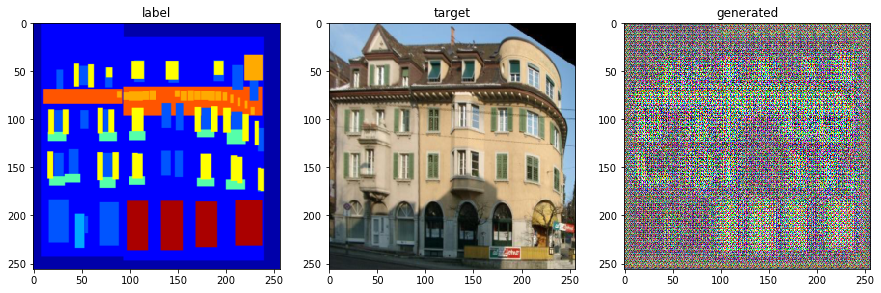

------------------------------ Model saved in file :  img2img_model.ckpt ------------------------------
EPOCH : 10, time : Thu Aug 17 11:51:57 2017, during : 4462.47, gen loss : 31.5321, discri loss : 0.319079
1.0 -0.999022 -0.087942


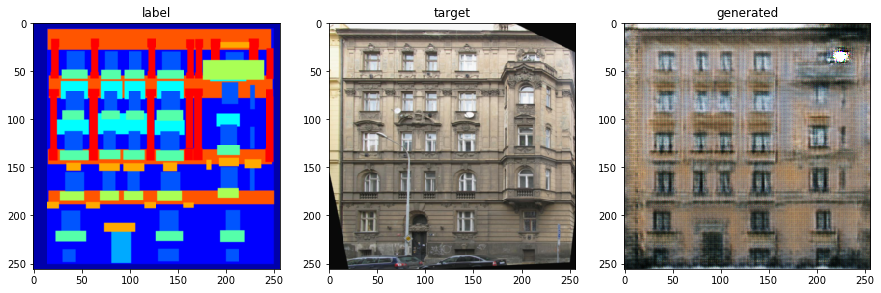

------------------------------ Model saved in file :  img2img_model.ckpt ------------------------------
EPOCH : 20, time : Thu Aug 17 13:06:02 2017, during : 4445.39, gen loss : 28.5725, discri loss : 0.0786481
1.0 -1.0 -0.0687217


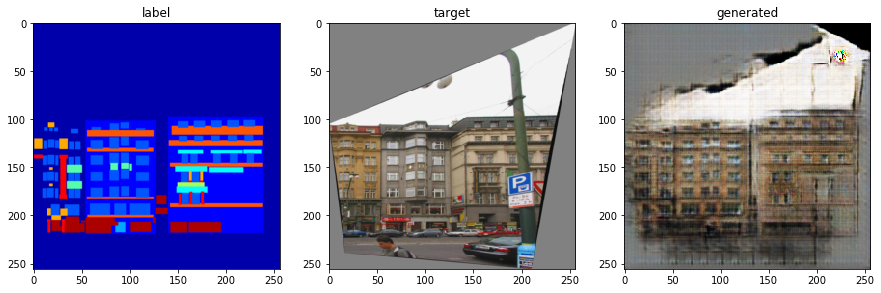

------------------------------ Model saved in file :  img2img_model.ckpt ------------------------------
EPOCH : 30, time : Thu Aug 17 14:19:56 2017, during : 4434.15, gen loss : 26.4272, discri loss : 0.0553391
1.0 -1.0 -0.00653267


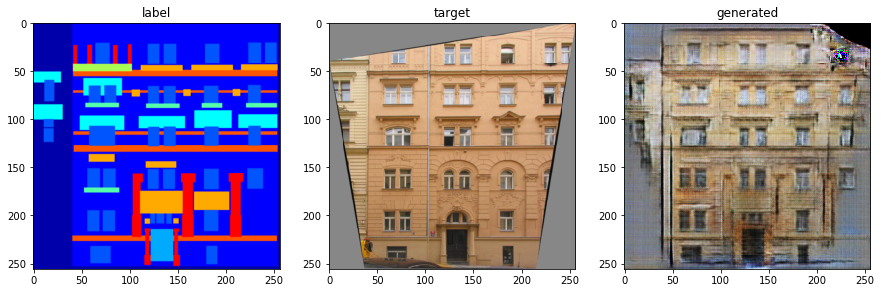

------------------------------ Model saved in file :  img2img_model.ckpt ------------------------------
EPOCH : 40, time : Thu Aug 17 15:33:50 2017, during : 4434.15, gen loss : 24.4438, discri loss : 0.17761
1.0 -0.99998 -0.102977


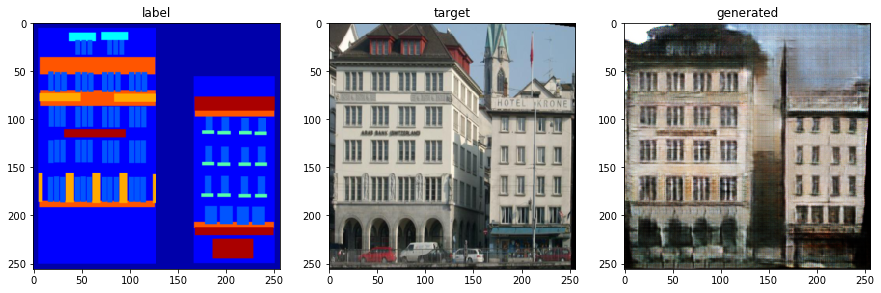

------------------------------ Model saved in file :  img2img_model.ckpt ------------------------------
EPOCH : 50, time : Thu Aug 17 16:47:49 2017, during : 4438.67, gen loss : 24.9125, discri loss : 0.531778
1.0 -0.99993 -0.0349117


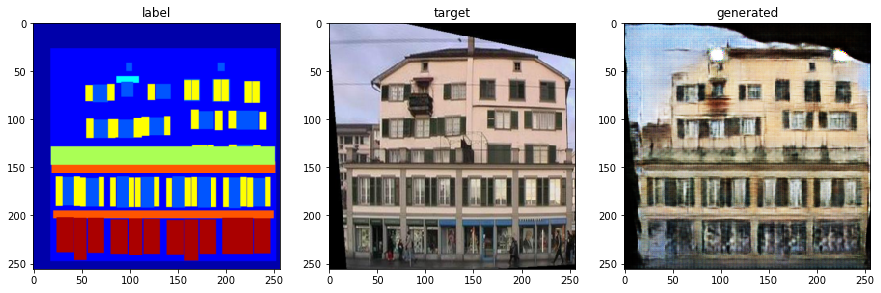

In [11]:
sess =tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# sess = tf.InteractiveSession()
# saver = tf.train.Saver()
# saver.restore(sess, 'img2img_model.ckpt')

t1 = time.time()
for epo in range(EPOCH+1):
    if epo % 10 == 0:
            save_path = saver.save(sess, 'img2img_model.ckpt')
            print('-'*30, "Model saved in file : ", save_path,'-'*30)

    for i in range(train_image_numbers):
        ind = np.random.randint(train_image_numbers)
        target_img = read_img(TRAIN_DATA_PATH+target_image_names[ind])
        target_img = preprocess_img(np.expand_dims(target_img, axis=0))
        
        label_img = read_img(TRAIN_DATA_PATH+label_image_names[ind])
        label_img = preprocess_img(np.expand_dims(label_img, axis=0))
        
        if i % 1000 ==0 and epo%10 == 0:
            t2 = time.time()
            tout,gloss,dloss = sess.run([outputs,gen_loss, discrim_loss], feed_dict={inputs:label_img, targets:target_img})
            print('EPOCH : %d, time : %s, during : %g, gen loss : %g, discri loss : %g'%(epo, time.ctime(),t2-t1,gloss, dloss))
            print(np.max(tout), np.min(tout), np.mean(tout))
            t1 = t2
            plt.figure(figsize=(15,15))
            plt.subplot(132)
            plt.title('target')
            target_img = deprocess_img(target_img)
            plt.imshow(visualize_img(np.squeeze(target_img)))
            
            plt.subplot(131)
            plt.title('label')
            label_img = deprocess_img(label_img)
            plt.imshow(visualize_img(np.squeeze(label_img)))
            
            plt.subplot(133)
            plt.title('generated')
            tout = deprocess_img(tout)
            tout = np.squeeze(tout)
            plt.imshow(visualize_img(tout))
            plt.show()
        
        # training random images
        sess.run(discrim_train,{inputs:label_img, targets:target_img} )
        
        ind = np.random.randint(train_image_numbers)
        target_img = read_img(TRAIN_DATA_PATH+target_image_names[ind])
        target_img = preprocess_img(np.expand_dims(target_img, axis=0))
        label_img = read_img(TRAIN_DATA_PATH+label_image_names[ind])
        label_img = preprocess_img(np.expand_dims(label_img, axis=0))
        sess.run(discrim_train,{inputs:label_img, targets:target_img} )
        
        ind = np.random.randint(train_image_numbers)
        target_img = read_img(TRAIN_DATA_PATH+target_image_names[ind])
        target_img = preprocess_img(np.expand_dims(target_img, axis=0))
        label_img = read_img(TRAIN_DATA_PATH+label_image_names[ind])
        label_img = preprocess_img(np.expand_dims(label_img, axis=0))
        sess.run(discrim_train,{inputs:label_img, targets:target_img} )        
        
        ind = np.random.randint(train_image_numbers)
        target_img = read_img(TRAIN_DATA_PATH+target_image_names[ind])
        target_img = preprocess_img(np.expand_dims(target_img, axis=0))
        label_img = read_img(TRAIN_DATA_PATH+label_image_names[ind])
        label_img = preprocess_img(np.expand_dims(label_img, axis=0))
        sess.run(gen_train,{inputs:label_img, targets:target_img} )
    

# test data set

In [12]:
# get training label, target image names
label_image_names = list()
target_image_names = list()

for (path, dir, files) in os.walk(TEST_DATA_PATH):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.png':
            label_image_names.append(filename)
        elif ext == '.jpg':
            target_image_names.append(filename)            

label_image_names.sort()
target_image_names.sort()
test_image_numbers = len(label_image_names)
print(test_image_numbers)

100


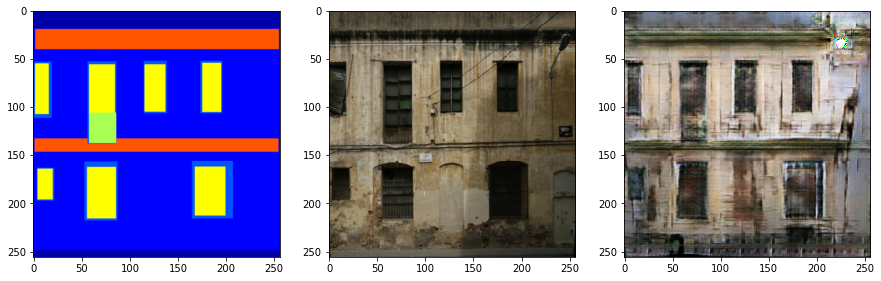

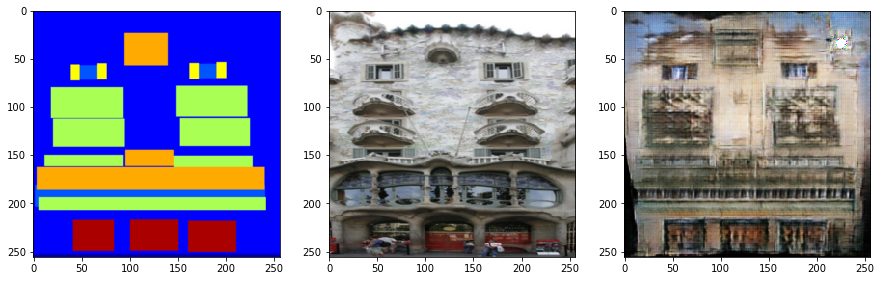

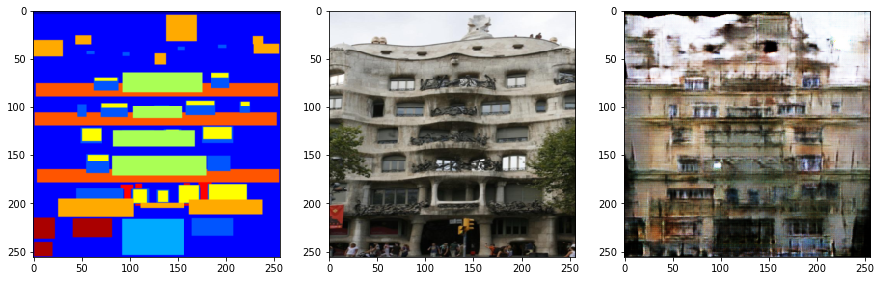

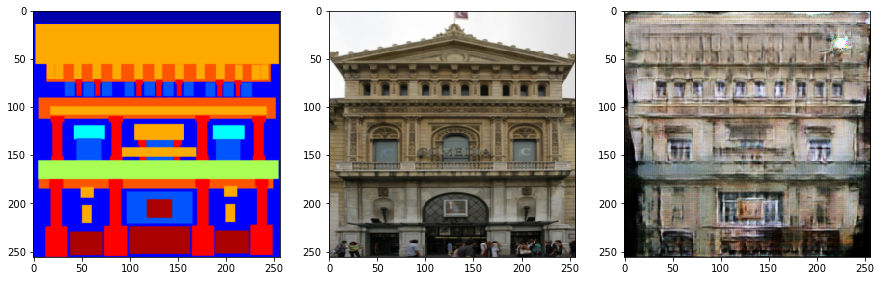

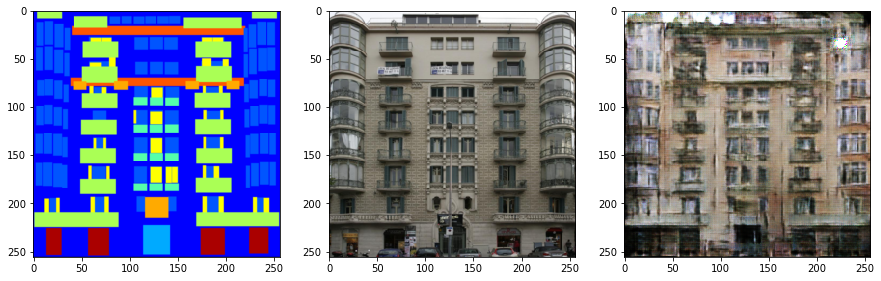

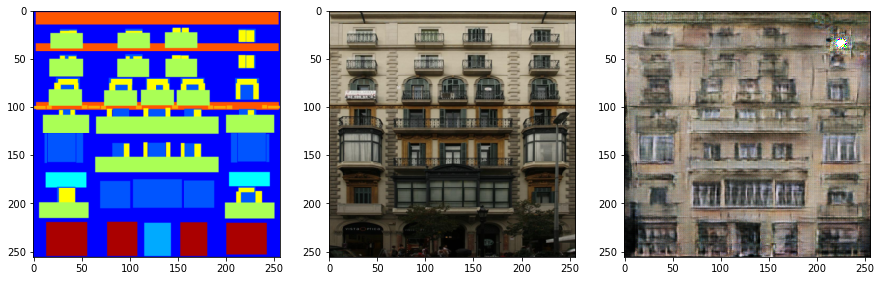

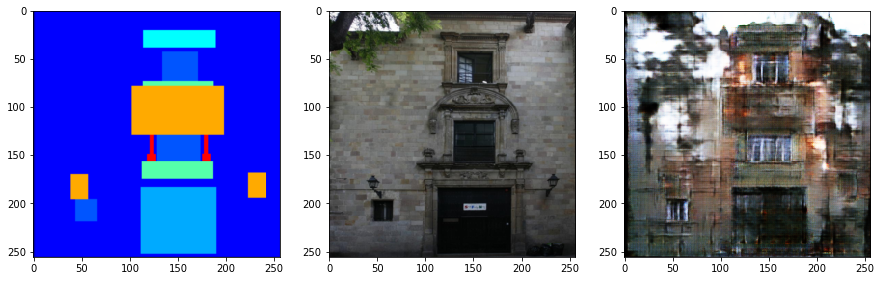

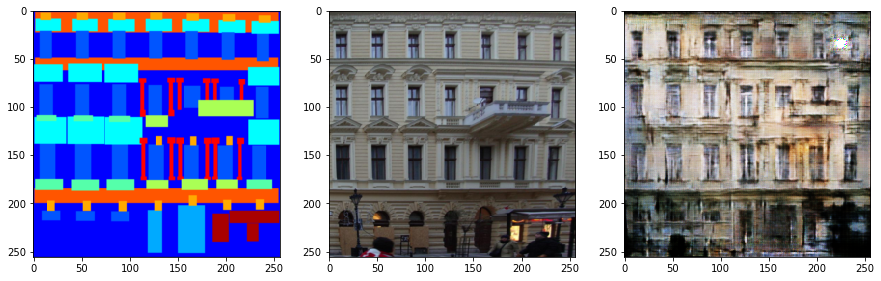

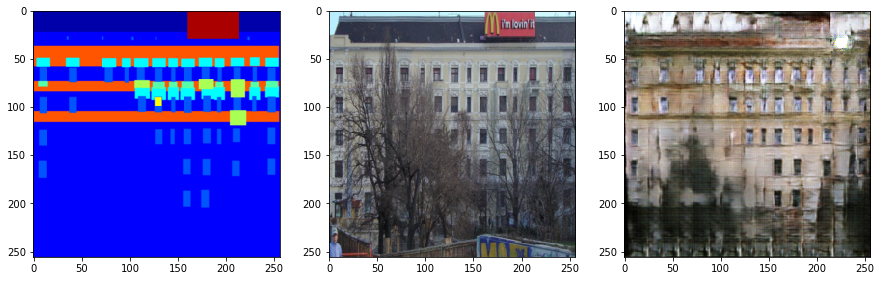

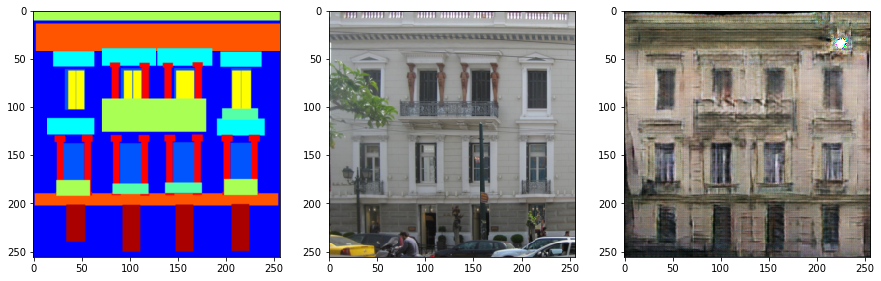

In [13]:
for i in range(10):
    plt.figure(figsize=(15,15))

    test_lab_img = read_img(TEST_DATA_PATH+label_image_names[i])
    plt.subplot(131)
    plt.imshow(test_lab_img)
    test_lab_img = preprocess_img(np.expand_dims(test_lab_img, axis=0))

    test_tar_img = read_img(TEST_DATA_PATH+target_image_names[i])
    plt.subplot(132)
    plt.imshow(test_tar_img)
    test_tar_img = preprocess_img(np.expand_dims(test_tar_img, axis=0))

    test_out = sess.run(outputs, {inputs:test_lab_img, targets:test_tar_img})
    plt.subplot(133)
    plt.imshow(visualize_img(deprocess_img(np.squeeze(test_out))))
    plt.show()